##### Mediapipe를 이용해 손으로 그림 그리기

In [2]:
import cv2 
import mediapipe as mp  
from PIL import ImageFont, ImageDraw, Image
import numpy as np

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_drawing_styles = mp.solutions.drawing_styles

list_ball_location = []
history_ball_locations = []

In [4]:
# 지정한 위치에 대해 선(그림)을 그리는 함수

def draw_ball_location(image, locations):
    for i in range(len(locations)-1):
        if locations[0] is None or locations[1] is None:
            continue

        cv2.line(image, tuple(locations[i]), tuple(locations[i+1]), (0, 255, 255), 3)

    return image

##### 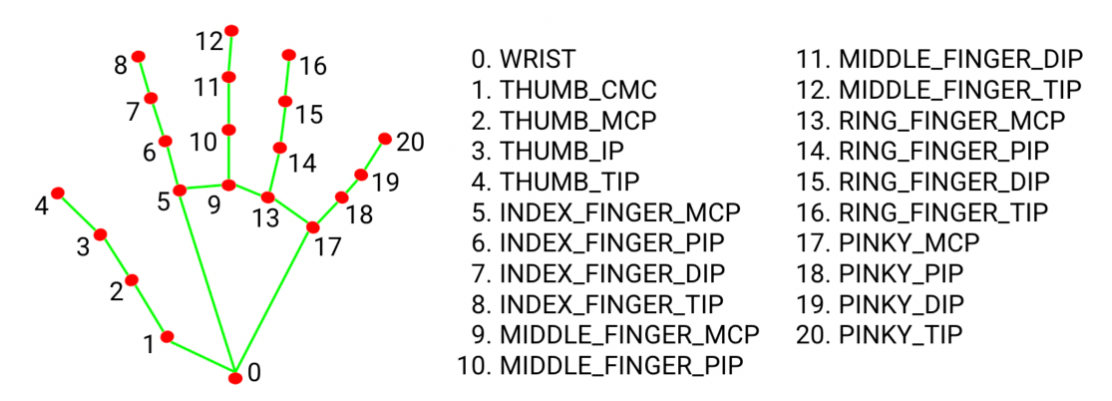
### 그리기 : 검지만 핀 경우
### 이동 : 다 접은 경우 (주먹을 쥔 경우)
### 그림 지우기 : 손가락을 다 핀 경우

In [5]:
cap = cv2.VideoCapture(0)  # 웹캠을 불러옴

with mp_hands.Hands(min_detection_confidence=0.5,min_tracking_confidence=0.5) as hands: # 정답으로 예측하는 범위의 최소 감지 및 추적 신뢰도 지정
  while cap.isOpened():
    success, image = cap.read()

    if not success:
      print("Ignoring empty camera frame.")
      continue

    # 좌우반전 및 RGB 변환
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

    # 성능 향상을 위해 이미지 작성 여부를 False로 지정함
    image.flags.writeable = False
    results = hands.process(image)

    # 손 동작 감지
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_height, image_width, _ = image.shape

    if results.multi_hand_landmarks:
      # multi_hand_landmarks : 감지 / 추적된 손의 집합
      # 각 landmark는 이미지 폭과 높이로 0~1 범위에서 정규화됨
      for hand_landmarks in results.multi_hand_landmarks: 
       
        # 엄지를 제외한 나머지 4개 손가락의 마디 위치 관계를 확인하여 플래그 변수를 설정
        # 손가락을 일자로 편 상태인지 확인 함
        thumb_finger_state = 0
        if hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_CMC].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].y * image_height:
          if hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_MCP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].y * image_height:
            if hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_IP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y * image_height:
              thumb_finger_state = 1
              ## image_height은 아래로 갈 수록 증가함
              ## 연속된 위치의 관절값에 image_height을 넣어 계산하고 비교했을 때, 아래쪽의 관절 부분 값이 더 크다면 상대적으로 아래에 위치함을 알 수 있음
              ## TIP에 해당하는 값이 가장 작게 나오는 경우 해당 손가락은 일자로 펴져 있다고 할 수 있음

        index_finger_state = 0
        if hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_MCP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].y * image_height:
          if hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_PIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].y * image_height:
            if hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height:
              index_finger_state = 1
              # 검지 손가락이 일자로 펴진 상태

        middle_finger_state = 0
        if hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_MCP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].y * image_height:
          if hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_PIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_DIP].y * image_height:
            if hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_DIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y * image_height:
              middle_finger_state = 1
              # 중지 손가락이 일자로 펴진 상태

        ring_finger_state = 0
        if hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_MCP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].y * image_height:
          if hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_PIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_DIP].y * image_height:
            if hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_DIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].y * image_height:
              ring_finger_state = 1
              # 약지 손가락이 일자로 펴진 상태

        pinky_finger_state = 0
        if hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_MCP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].y * image_height:
          if hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_PIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_DIP].y * image_height:
            if hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_DIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].y * image_height:
              pinky_finger_state = 1
              # 새끼 손가락이 일자로 펴진 상태

        use_pen = False
        if hand_landmarks.landmark[mp_hands.HandLandmark.THUMB_TIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].y * image_height:
          if hand_landmarks.landmark[mp_hands.HandLandmark.MIDDLE_FINGER_TIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].y * image_height:
            if hand_landmarks.landmark[mp_hands.HandLandmark.RING_FINGER_TIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].y * image_height:
              if hand_landmarks.landmark[mp_hands.HandLandmark.PINKY_TIP].y * image_height > hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_DIP].y * image_height:
                if index_finger_state:
                  use_pen = True
                  ## 검지 손가락의 2번째 마디가 다른 손가락의 끝부분 image_height 보다 작다면, 다른 손가락들은 접혀있고 검지만 펴진 상태로 해석 가능함
       
        use_eraser = False
        if thumb_finger_state == 1 and index_finger_state == 1 and middle_finger_state == 1 and ring_finger_state == 1 and pinky_finger_state == 1:
          use_eraser = True
          ## 모든 손가락이 다 펴진 경우 그림 지우기 모드

        use_move = False
        if   index_finger_state == 0 and middle_finger_state == 0 and ring_finger_state == 0 and pinky_finger_state == 0:
          use_move = True
          ## 모든 손가락이 다 접힌 경우 이동 모드

        image = Image.fromarray(image)  # numpy 배열로 되어있는 이미지를 PIL로 변환
        draw = ImageDraw.Draw(image)
       
        text = ""
        if use_pen == True:
          text = "펜"

        elif use_eraser == True:
          text = "지우개"
       
        elif use_move == True:
          text = "이동"
       

        if text == '펜':
            x = int(hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width)
            y = int(hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height)

            list_ball_location.append((x,y))
            # 펜 모드에서 지정한 위치를 draw_ball_location 함수에 넘기기 위해 배열에 append함
           
        elif text == '이동':
          history_ball_locations.append(list_ball_location.copy())
          list_ball_location.clear()

        elif text == '지우개':
            history_ball_locations.clear()
            list_ball_location.clear()

        font = ImageFont.truetype("fonts/gulim.ttc", 80)
        # font =  cv2.FONT_HERSHEY_PLAIN
        # w, h = font.getsize(text)

        x = 50
        y = 50

        # draw.rectangle((x, y, x + w, y + h), fill='black')
        draw.text((x, y),  text, font=font, fill=(255, 255, 255))   # 현재 모드를 출력함
        image = np.array(image)

        # 손가락 뼈대를 그려줌
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

    image = draw_ball_location(image, list_ball_location)
    # 펜 모드에서 손가락으로지정한 위치를 그림으로 표현함

    for ball_locations in history_ball_locations:
      image = draw_ball_location(image, ball_locations)

    cv2.imshow('MediaPipe Hands', image)

    if cv2.waitKey(5) & 0xFF == 27:
      break

cap.release()

KeyboardInterrupt: 

##### 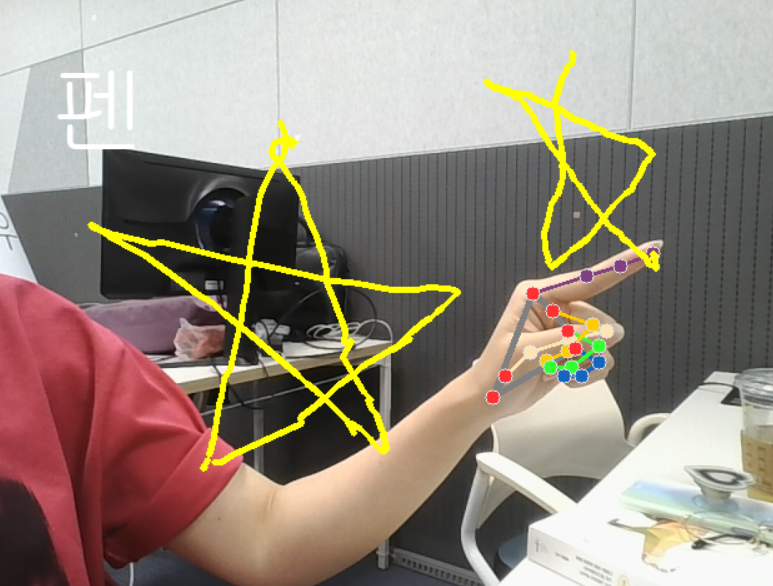
##### 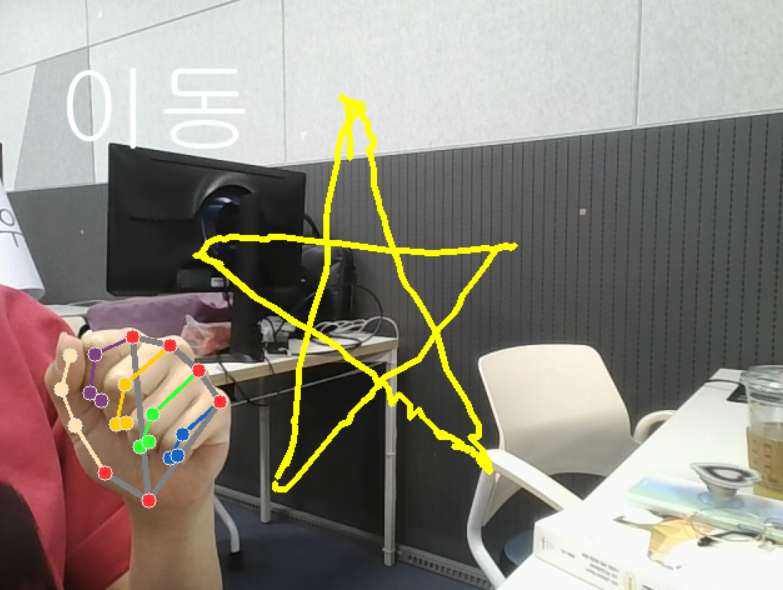
##### 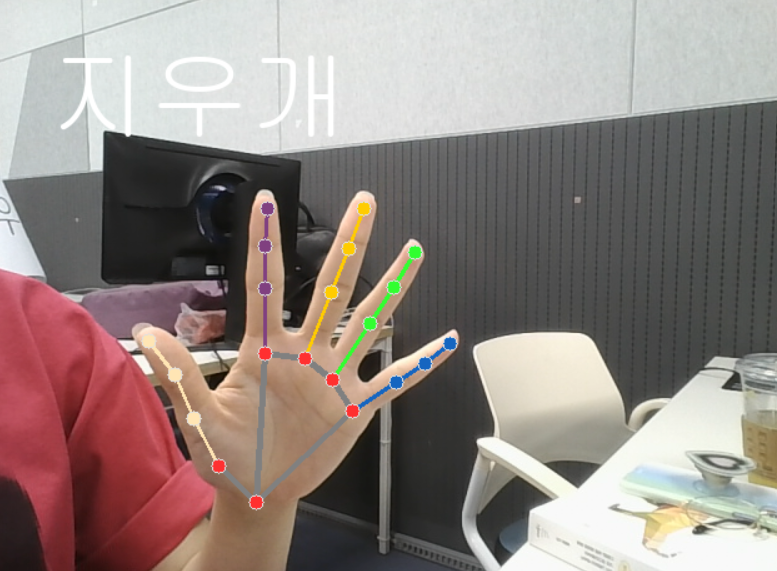